In [1]:
import numpy as np
import pandas as pd
from scipy.fft import fft, ifft, fftfreq
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from vplot import colors
import astropy.units as u
import rebound

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [56]:
# Secondary stability indicators

def outer_ecc_at_crossing(inner_semi, outer_semi, inner_ecc):
    # Returns the eccentricity of the outer planet at which two orbits overlap.
    return 1. - inner_semi/outer_semi * (1. + inner_ecc)

def hadden_lithwick_boundary(d_semi, b_semi, d_ecc):
    e_cross = b_semi / d_semi - 1.
    critical_ecc_mag = e_cross/np.sqrt(2.) \
                        * np.exp(-2.2 * np.power(float(((0.26 + 1.07)*u.earthMass)/(0.12*u.solMass)), 1./3.) \
                        * np.power(b_semi/(b_semi - d_semi), 4./3.))
    return np.sqrt(2.) * critical_ecc_mag - d_ecc

# Eccentricity space

The following creates Fig. 1.

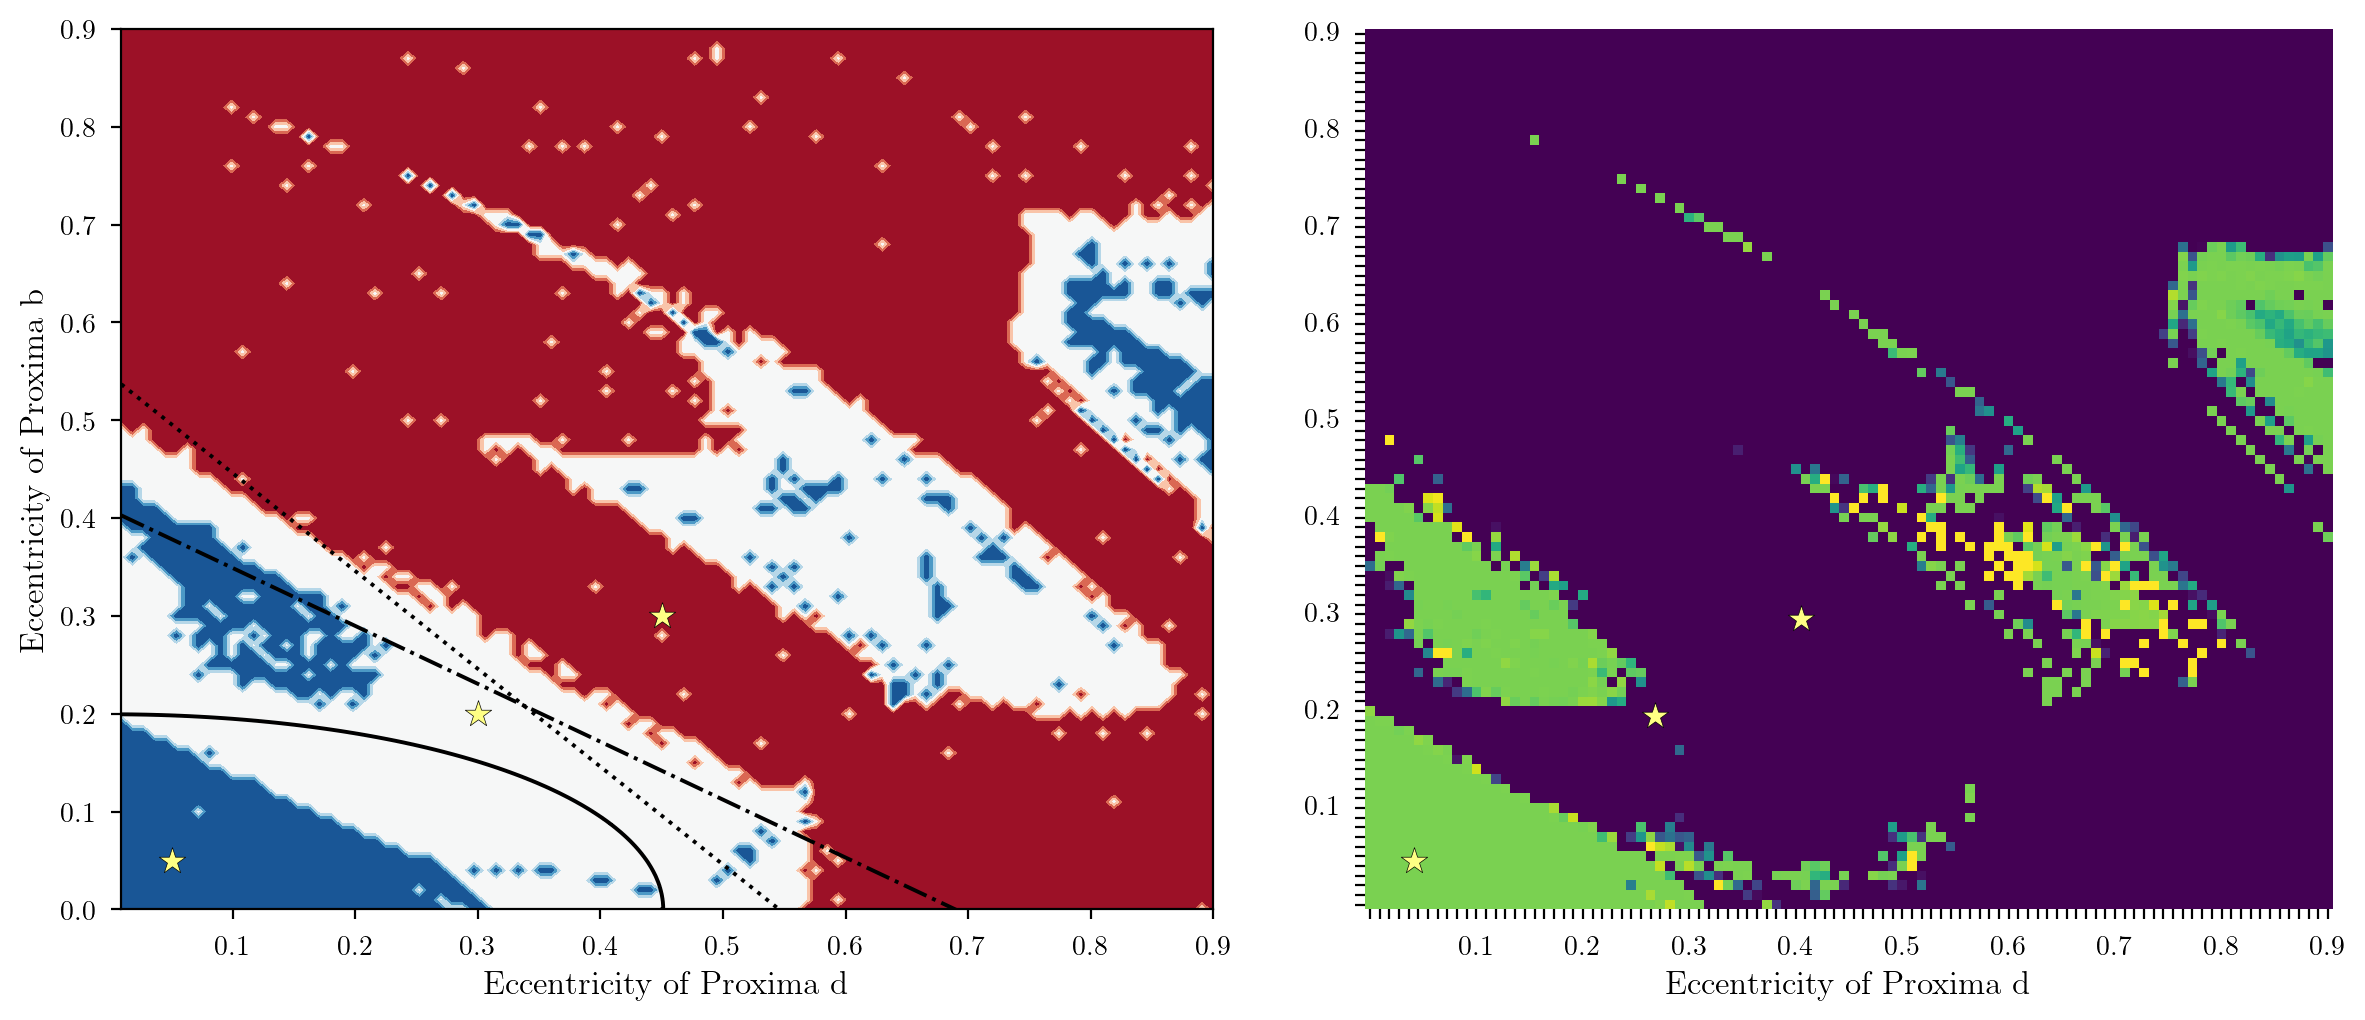

In [57]:
megno_map_file = '~/Documents/GitHub/ProximaEvolution/hill-stability/ecc-megno-2.txt'
megno_map_supp = '~/Documents/GitHub/ProximaEvolution/hill-stability/ecc-megno-supp.txt'
hill_stab_file = '~/Documents/GitHub/ProximaEvolution/hill-stability/proxhillstabecc.txt'

# megno_map_file = 'ecc-megno.txt'
# megno_supp_file = None
# hill_stab_file = 'proxhillstabecc.txt'

column_names = ['d_mass', 'b_mass', 'd_semi', 'b_semi', 'd_ecc', 'b_ecc', 'd_inc', 'b_inc', 'd_Omega', 'b_Omega', 'd_pomega', 'b_pomega', 'megno']
df = pd.read_csv(megno_map_file, sep=' ', names=column_names, index_col=False)

# Apply masks
stable_df = df.mask(np.fabs(df['megno'] - 2.) > 1.0e-2).mask(df['megno'] == 10.).dropna()
unstable_df = df.mask(np.fabs(df['megno'] - 2.) < 1.0e-2).mask(df['megno'] == 10.).dropna()
escape_df = df.mask(df['megno'] != 10.).dropna() # we arbitrarily set MEGNO to 10.0 where escape occurs

# Hill stability data (calculated with prox_hill_stab.c)
hill_stab_cols = ['exact', 'approx', 'd_mass', 'b_mass', 'd_semi', 'b_semi',
                'd_ecc', 'b_ecc', 'd_aper', 'b_aper', 'd_inc', 'b_inc',
                'd_lasc', 'b_lasc', 'd_mean_an', 'b_mean_an']
hillstab = pd.read_csv(hill_stab_file, sep=' ', names=hill_stab_cols, index_col=False)

# Cleaning up the data
df = df.drop_duplicates(subset=['d_ecc', 'b_ecc'])
if megno_map_supp != None:
    df_supp = pd.read_csv(megno_map_supp, sep=' ', names=column_names, index_col=False)
    df_supp = df_supp.drop_duplicates(subset=['d_ecc', 'b_ecc'])
    df = pd.concat([df, df_supp]).drop_duplicates(subset=['d_ecc', 'b_ecc'])

d_ecc_list = list(df['d_ecc'])
b_ecc_list = list(df['b_ecc'])
d_ecc = []
b_ecc = []
for de in d_ecc_list:
    if de not in d_ecc:
        d_ecc.append(de)
for be in b_ecc_list:
    if be not in b_ecc:
        b_ecc.append(be)
for de in d_ecc:
    for be in b_ecc:
        if df[(np.abs(df['d_ecc'] - de) <= 0.005) & (np.abs(df['b_ecc'] - be) <= 0.005)].index.tolist() == []:
            new_row = {'d_ecc': de, 'b_ecc': be, 'megno': 0.}
            df = df.append(new_row, ignore_index=True)
df = df.drop_duplicates(subset=['d_ecc', 'b_ecc'])
df = df.sort_values(by=['b_ecc', 'd_ecc'])

# Make MEGNO heatmap
megno_map = np.zeros((100, 91))
for k in range(len(df['megno'])):
    i = k % 100
    j = int(np.floor(k/100))
    m = df['megno'].iloc[k]
    if np.isnan(m):
        m = 10.
    elif m > 10.:
        m = 10.
    elif m < 0.:
        m = 0.
    megno_map[i][j] = m
    
# Assign quasi-periodic/chaotic/unstable designation
orbit_type = np.zeros((100, 91))
for k in range(len(df['megno'])):
    i = k % 100
    j = int(np.floor(k/100))
    if np.fabs(df['megno'].iloc[k] - 2.) <= 1e-2: # Criterion of Hinse et al. (2010)
        orbit_type[i][j] = 1. # quasi-periodic
    elif (df['megno'].iloc[k] == 10.):
        orbit_type[i][j] = 0. # unstable -- ejection occurs
#     elif df['megno'].iloc[k] == 0.:
#         orbit_type[i][j] = 0.5 # no data -- for some reason, the simulation didn't finish
    else:
        orbit_type[i][j] = 0.5 # chaotic, but not necessarily unstable

# Make tick labels
d_tick_labels = np.round_(np.linspace(0., 0.9, 100), decimals=2)
b_tick_labels = np.round_(np.linspace(0., 0.9, 91), decimals=2)
d_tick_labels = [str(e) for e in d_tick_labels]
b_tick_labels = [str(e) for e in b_tick_labels]
for i, e in enumerate(d_tick_labels):
    if e not in str(np.linspace(0., 0.9, 10)):
        d_tick_labels[i] = ''
    else:
        d_tick_labels[i] = str(d_tick_labels[i])
for i, e in enumerate(b_tick_labels):
    if e not in str(np.linspace(0., 0.9, 10)):
        b_tick_labels[i] = ''
    else:
        b_tick_labels[i] = str(b_tick_labels[i])

X, Y = np.meshgrid(np.linspace(0.009, 0.9, 100), np.linspace(0., 0.9, 91))

# Create figure
fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi=200)
divider = make_axes_locatable(ax[1])
cmap = 'viridis_r'
# cax = divider.append_axes('right', size='5%', pad=0.1)
ax[0].contourf(X, Y, orbit_type.T, cmap='RdBu')
with sns.axes_style('ticks'):
    hm = sns.heatmap(megno_map.T,
                     vmin=0.,
                     vmax=10.,
                     cmap=cmap,
                     xticklabels=d_tick_labels,
                     yticklabels=b_tick_labels,
                     square=True,
                     cbar=True,
                     cbar_kws={'label':'Time-averaged MEGNO'},
                     cbar_ax=cax,
                     ax=ax[1]
                    )
    hm.set_yticklabels(hm.get_yticklabels(), rotation=0)

# Hill stability boundary
ax[0].tricontour(hillstab['d_ecc'],
                 hillstab['b_ecc'],
                 hillstab['exact'],
                 levels=[1.],
                 colors='k'
                )

# Limit of crossing orbits
d_ecc = np.array(d_ecc)
d_ecc.sort()
b_ecc_at_crossing = outer_ecc_at_crossing(0.029, 0.049, d_ecc)
ax[0].plot(d_ecc, b_ecc_at_crossing, c='k', ls='dashdot')

# Hadden-Lithwick stability boundary
hl_boundary = hadden_lithwick_boundary(0.029, 0.049, d_ecc)
ax[0].plot(d_ecc, hl_boundary, c='k', ls='dotted')

# Locations of simulations in Fig. 2
d_sample = np.array([0.05, 0.3, 0.45])
b_sample = np.array([0.05, 0.2, 0.3])
ax[0].scatter(d_sample, b_sample, marker='*', s=100, c='xkcd:pale yellow', edgecolor='k')
ax[1].scatter(d_sample*100., b_sample*100., marker='*', s=100, c='xkcd:pale yellow', edgecolor='k')

# Location of VPLanet simulation in AAS 241 presentation
# ax.scatter(0.0907129347973946, 0.09250015269796305, marker='*', s=200, c='xkcd:pale yellow', edgecolor='k')

ax[1].invert_yaxis()
ax[0].set_xlim(left=0.009)
ax[0].set_ylim(bottom=0.)
for a in ax:
    a.tick_params(which='minor', bottom=False, left=False)
    a.set_xlabel('Eccentricity of Proxima d')
ax[0].set_ylabel('Eccentricity of Proxima b');
# fig.savefig('varying-ecc.pdf', dpi=400, bbox_inches='tight')

## Sample simulations with output

The following creates Fig. 2. Note that the second cell below will run three REBOUND simulations that will last for several minutes each.

In [363]:
def conjunction_longitude(d, b):
    return (2.*b.l - d.l) % (2.*np.pi)

def resonant_argument_1(d, b):
    return (2.*b.l - d.l - d.pomega) % (2.*np.pi)

def resonant_argument_2(d, b):
    return (2.*b.l - d.l - b.pomega) % (2.*np.pi)

def resonant_argument_3(d, b):
    return (3.*b.l - d.l - 2.*d.pomega) % (2.*np.pi)

def resonant_argument_32(d, b):
    return (3.*b.l - 2.*d.l - d.pomega) % (2.*np.pi)

def crossing_orbit(d, b):
    cross = False
    d_dist_at_d_apocenter = d.a * (1. - d.e**2.)
    b_dist_at_d_apocenter = b.a * (1. - b.e**2.) / (1. + b.e * np.cos(d.pomega - b.pomega + np.pi))
    if d_dist_at_d_apocenter > b_dist_at_d_apocenter:
        cross = True
    return cross

def simulation_with_output(par, integrator='ias15', num_orbit=1.0e6, step_size=100, primary_mass=0.12, M=None):
    """
    Runs a REBOUND simulation with the specified orbital elements for Proxima d & b. Returns DataFrame with
    snapshots of the orbital elements taken every 100 timesteps.
    """
    m1, m2, a1, a2, e1, e2, i1, i2, Omega1, Omega2, pomega1, pomega2 = par # unpack parameters
    sim = None
    sim = rebound.Simulation()
    sim.integrator = integrator
    if integrator == 'whfast':
        sim.ri_whfast.safe_mode = False
        sim.ri_whfast.corrector = 11
    sim.add(m=primary_mass)                      # Proxima Centauri
    if M == None:
        sim.add(m=m1, a=a1, e=e1, inc=i1, Omega=Omega1, pomega=pomega1)  # Proxima d
        sim.add(m=m2, a=a2, e=e2, inc=i2, Omega=Omega2, pomega=pomega2)  # Proxima b
    else:
        M1, M2 = M
        sim.add(m=m1, a=a1, e=e1, inc=i1, Omega=Omega1, pomega=pomega1, M=M1)  # Proxima d
        sim.add(m=m2, a=a2, e=e2, inc=i2, Omega=Omega2, pomega=pomega2, M=M2)  # Proxima b
    star = sim.particles[0]
    d = sim.particles[1]
    b = sim.particles[2]
    sim.dt = 0.05 * d.P # timestep is 5% of Proxima d's orbital period
#     sim.dt = 0.01 * d.P # For System A from Barnes et al. (2015)
    b_per = b.P
#     orbits_cross = False
    sim.move_to_com()
    if integrator == 'ias15':
        sim.ri_ias15.min_dt = 1e-4 * sim.dt
    sim.init_megno()
    sim.exit_max_distance = 20.
    
    energy = sim.calculate_energy()
    conj = conjunction_longitude(d, b)
    phi1 = resonant_argument_1(d, b)
    phi2 = resonant_argument_2(d, b)
    phi3 = resonant_argument_3(d, b)
    phi32 = resonant_argument_32(d, b)
    output = [[0., a1, a2, e1, e2, i1, i2, Omega1, Omega2, pomega1,
               pomega2, d.l, b.l, 0., 0., 0., 0., energy, 0., conj,
               phi1, phi2, phi3, phi32]]
    
#     sim.integrate(num_orbit*b.P, exact_finish_time=False)
#     final_energy = sim.calculate_energy()
#     return energy, final_energy
    
    try:
        i = 0
        while sim.t <= num_orbit * b_per: # Integrate num_orbit orbits of Proxima b
#             if i % 1000 == 0:
#                 print(sim.t/(2.*np.pi))
            sim.steps(step_size)
            do = d.calculate_orbit(primary=star)
            bo = b.calculate_orbit(primary=star)
            megno = sim.calculate_megno()
            energy = sim.calculate_energy()
            conj = conjunction_longitude(do, bo)
            phi1 = resonant_argument_1(do, bo)
            phi2 = resonant_argument_2(do, bo)
            phi3 = resonant_argument_3(do, bo)
            phi32 = resonant_argument_32(do, bo)
            output.append([sim.t, do.a, bo.a, do.e, bo.e, do.inc, bo.inc, do.Omega, bo.Omega,
                           do.pomega, bo.pomega, do.l, bo.l, do.n, bo.n, do.d, bo.d, energy,
                           megno, conj, phi1, phi2, phi3, phi32])
#             if crossing_orbits(do, bo):
#                 orbits_cross = True
            i += 1
    except rebound.Escape as ex:
        print(ex)
    megno = sim.calculate_megno()
#     print(orbits_cross)
    column_names = ['time', 'd_semi', 'b_semi', 'd_ecc', 'b_ecc', 'd_inc', 'b_inc', 'd_Omega', 'b_Omega',
                    'd_pomega', 'b_pomega', 'd_lambda', 'b_lambda', 'd_mm', 'b_mm', 'd_dist', 'b_dist',
                    'energy', 'megno', 'conj', 'phi1', 'phi2', 'phi3', 'phi32']
    return pd.DataFrame(data=output, columns=column_names)

In [364]:
# Example case with quasi-periodic motion
e1 = 0.05
e2 = 0.05
min_mass1 = float(0.26 * u.earthMass/u.solMass)
min_mass2 = float(1.07 * u.earthMass/u.solMass)
obs_inc1 = 133.
obs_inc2 = 133.
m1 = min_mass1 / np.sin(obs_inc1)
m2 = min_mass2 / np.sin(obs_inc2)
a1 = 0.029
a2 = 0.049
i1 = 0.
i2 = 0.
Omega1 = 0.
Omega2 = np.pi
pomega1 = 0.
pomega2 = np.pi
par = (m1, m2, a1, a2, e1, e2, i1, i2, Omega1, Omega2, pomega1, pomega2)
stable_sim = simulation_with_output(par, integrator='whfast')

# Example case with chaotic motion 
e1 = 0.29
e2 = 0.27
par = (m1, m2, a1, a2, e1, e2, i1, i2, Omega1, Omega2, pomega1, pomega2)
chaotic_sim = simulation_with_output(par, integrator='whfast')

# Example case with ejection
e1 = 0.45
e2 = 0.3
par = (m1, m2, a1, a2, e1, e2, i1, i2, Omega1, Omega2, pomega1, pomega2)
unstable_sim = simulation_with_output(par)

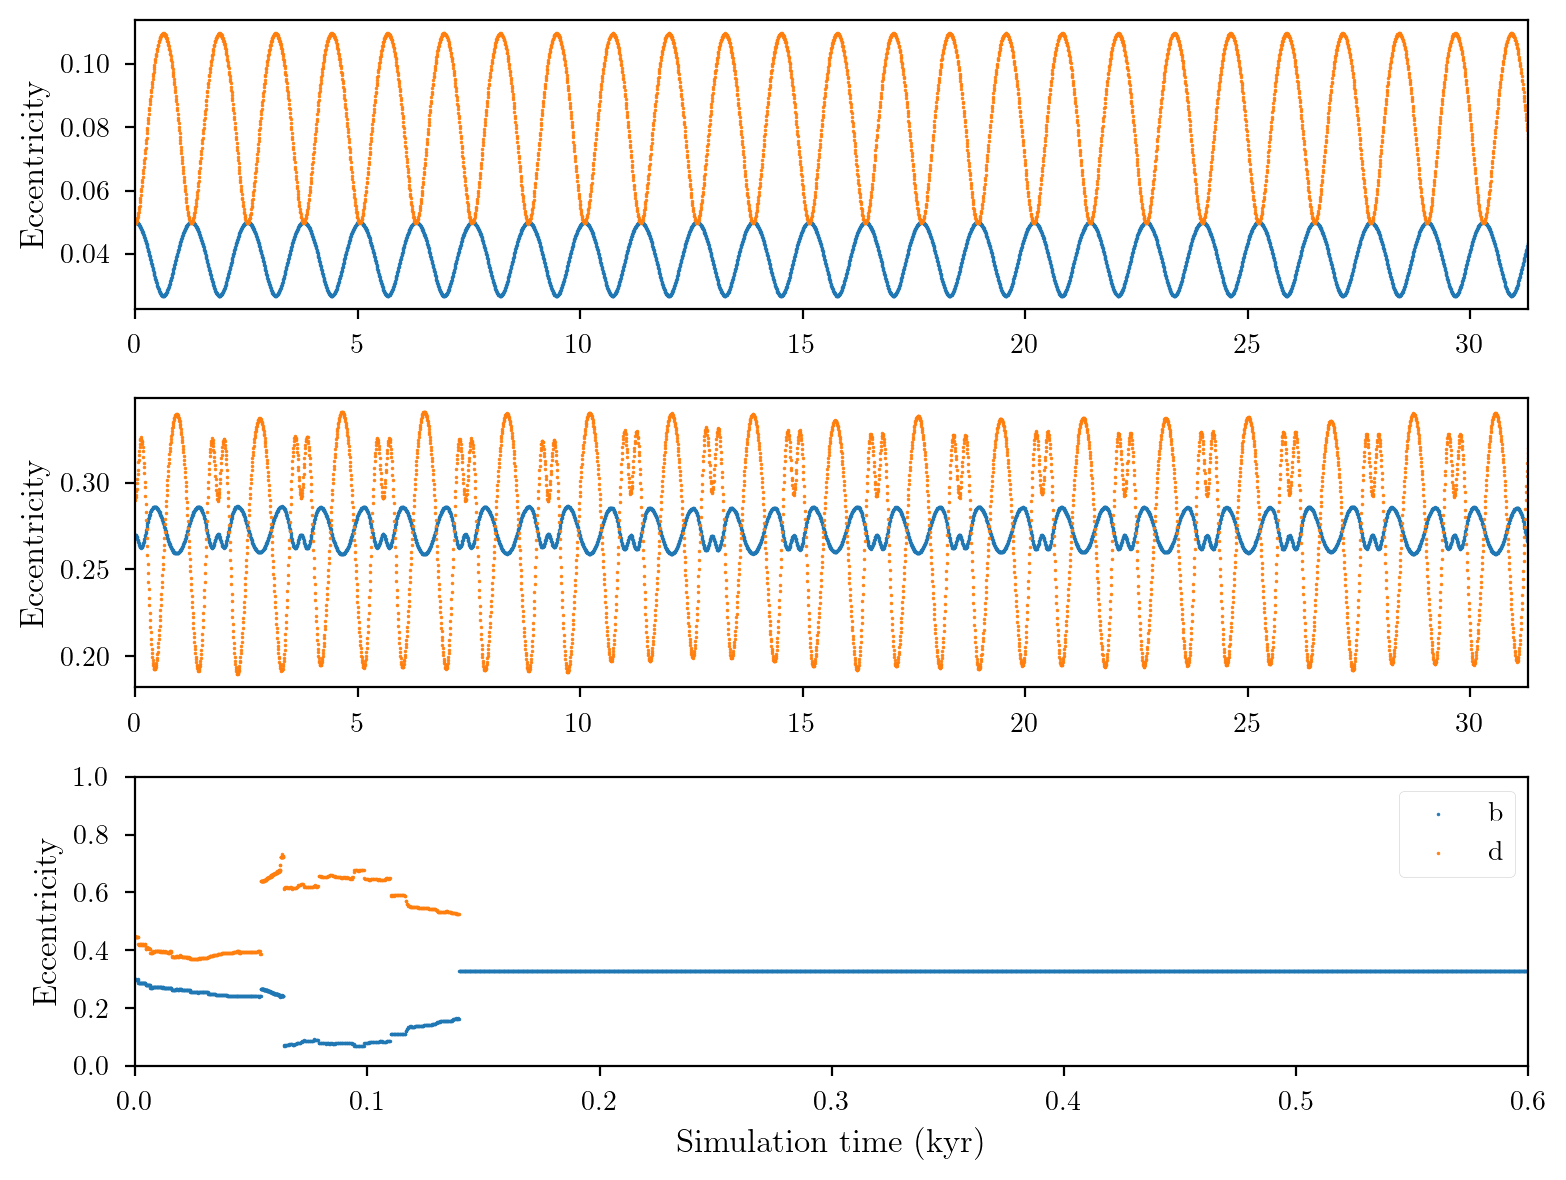

In [665]:
norm = 2. * np.pi * 1000. # conversion from REBOUND time units into kyr

stable_time = [stable_sim['time'].iloc[i]/norm for i in stable_sim.index if i % 100 == 0]
stable_d_ecc = [stable_sim['d_ecc'].iloc[i] for i in stable_sim.index if i % 100 == 0]
stable_b_ecc = [stable_sim['b_ecc'].iloc[i] for i in stable_sim.index if i % 100 == 0]
chaotic_time = [chaotic_sim['time'].iloc[i]/norm for i in chaotic_sim.index if i % 100 == 0]
chaotic_d_ecc = [chaotic_sim['d_ecc'].iloc[i] for i in chaotic_sim.index if i % 100 == 0]
chaotic_b_ecc = [chaotic_sim['b_ecc'].iloc[i] for i in chaotic_sim.index if i % 100 == 0]
unstable_time = [unstable_sim['time'].iloc[i]/norm for i in unstable_sim.index if i % 10 == 0]
unstable_d_ecc = [unstable_sim['d_ecc'].iloc[i] for i in unstable_sim.index if i % 10 == 0]
unstable_b_ecc = [unstable_sim['b_ecc'].iloc[i] for i in unstable_sim.index if i % 10 == 0]


fig, ax = plt.subplots(3, 1, figsize=(8, 6), dpi=200)
ax[0].scatter(stable_time, stable_b_ecc, s=1., label='b')
ax[0].scatter(stable_time, stable_d_ecc, s=1., label='d')
ax[1].scatter(chaotic_time, chaotic_b_ecc, s=1., label='b')
ax[1].scatter(chaotic_time, chaotic_d_ecc, s=1., label='d')
ax[2].scatter(unstable_time, unstable_b_ecc, s=1., label='b')
ax[2].scatter(unstable_time, unstable_d_ecc, s=1., label='d')
for a in ax:
    a.set_xlim(left=0.)
    a.set_ylabel('Eccentricity')
ax[2].set_xlabel('Simulation time (kyr)')
ax[0].set_xlim(right=max(stable_sim['time']/norm))
ax[1].set_xlim(right=max(chaotic_sim['time']/norm))
ax[2].set_xlim(right=0.6)
ax[2].set_ylim(top=1., bottom=0.)
ax[2].legend(loc=0);
# fig.savefig('evols-d05b05-d40b10-d30b50.pdf', bbox_inches='tight')

The MEGNO diverges (i.e., $\langle Y \rangle \not\to 2$) for the middle case. However, without this evaluation of the MEGNO the chaos is not obvious. Take the eccentricity of Proxima b in this scenario. We perform a Fourier transform of these data in order to determine how many frequencies are present.

In [506]:
# Intervals
t = chaotic_sim['time']

# Number of data points
N = len(t)
half_N = N // 2

# Sample spacing
T = t.iloc[-1] / N

# Transform to frequency space
b_ecc = chaotic_sim['b_ecc']
b_ecc -= b_ecc.mean()
ecc_fourier = fft(list(b_ecc))
freq = fftfreq(N, T)[:half_N]

# Transform to period space
period_years = [1./(2.*np.pi*f) for f in freq[1:]]

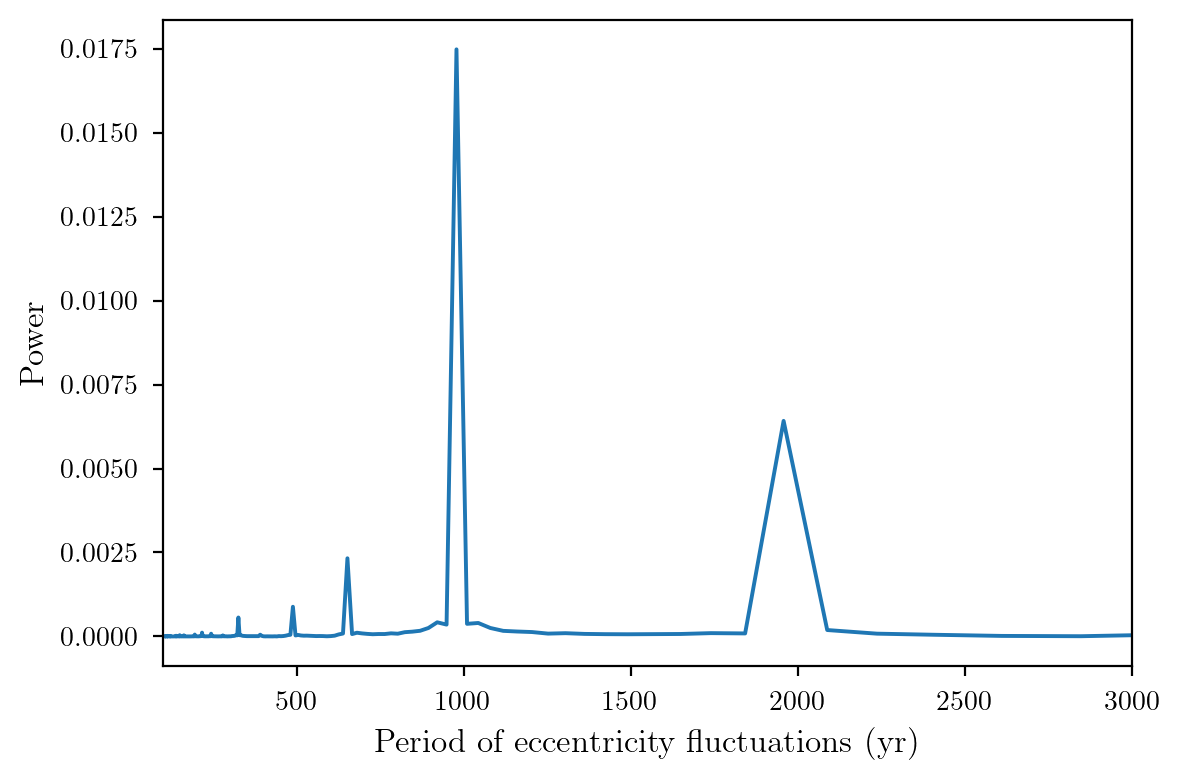

In [645]:
fig, ax = plt.subplots(1, 1, dpi=200)
ax.plot(period_years, np.abs(ecc_fourier[1:half_N])/half_N)
ax.set_xlim(1.e2, 3.e3)
# ax.set_ylim(bottom=1.e-5)
ax.set_xlabel('Period of eccentricity fluctuations (yr)')
ax.set_ylabel('Power');

We find that there are at least three frequencies present.

In [646]:
e1 = 0.29
e2 = 0.27
min_mass1 = float(0.26 * u.earthMass/u.solMass)
min_mass2 = float(1.07 * u.earthMass/u.solMass)
obs_inc1 = 133.
obs_inc2 = 133.
m1 = min_mass1 / np.sin(obs_inc1)
m2 = min_mass2 / np.sin(obs_inc2)
a1 = 0.029
a2 = 0.049
i1 = 0.
i2 = 0.
Omega1 = 0.
Omega2 = np.pi
pomega1 = 0.
pomega2 = np.pi
par = (m1, m2, a1, a2, e1, e2, i1, i2, Omega1, Omega2, pomega1, pomega2)
chaos_1 = simulation_with_output(par, integrator='whfast')

# e1 = 0.75
# e2 = 0.27
# par = (m1, m2, a1, a2, e1, e2, i1, i2, Omega1, Omega2, pomega1, pomega2)
# chaos_2 = simulation_with_output(par, integrator='whfast')

# e1 = 0.5
# e2 = 0.
# par = (m1, m2, a1, a2, e1, e2, i1, i2, Omega1, Omega2, pomega1, pomega2)
# chaos_3 = simulation_with_output(par)

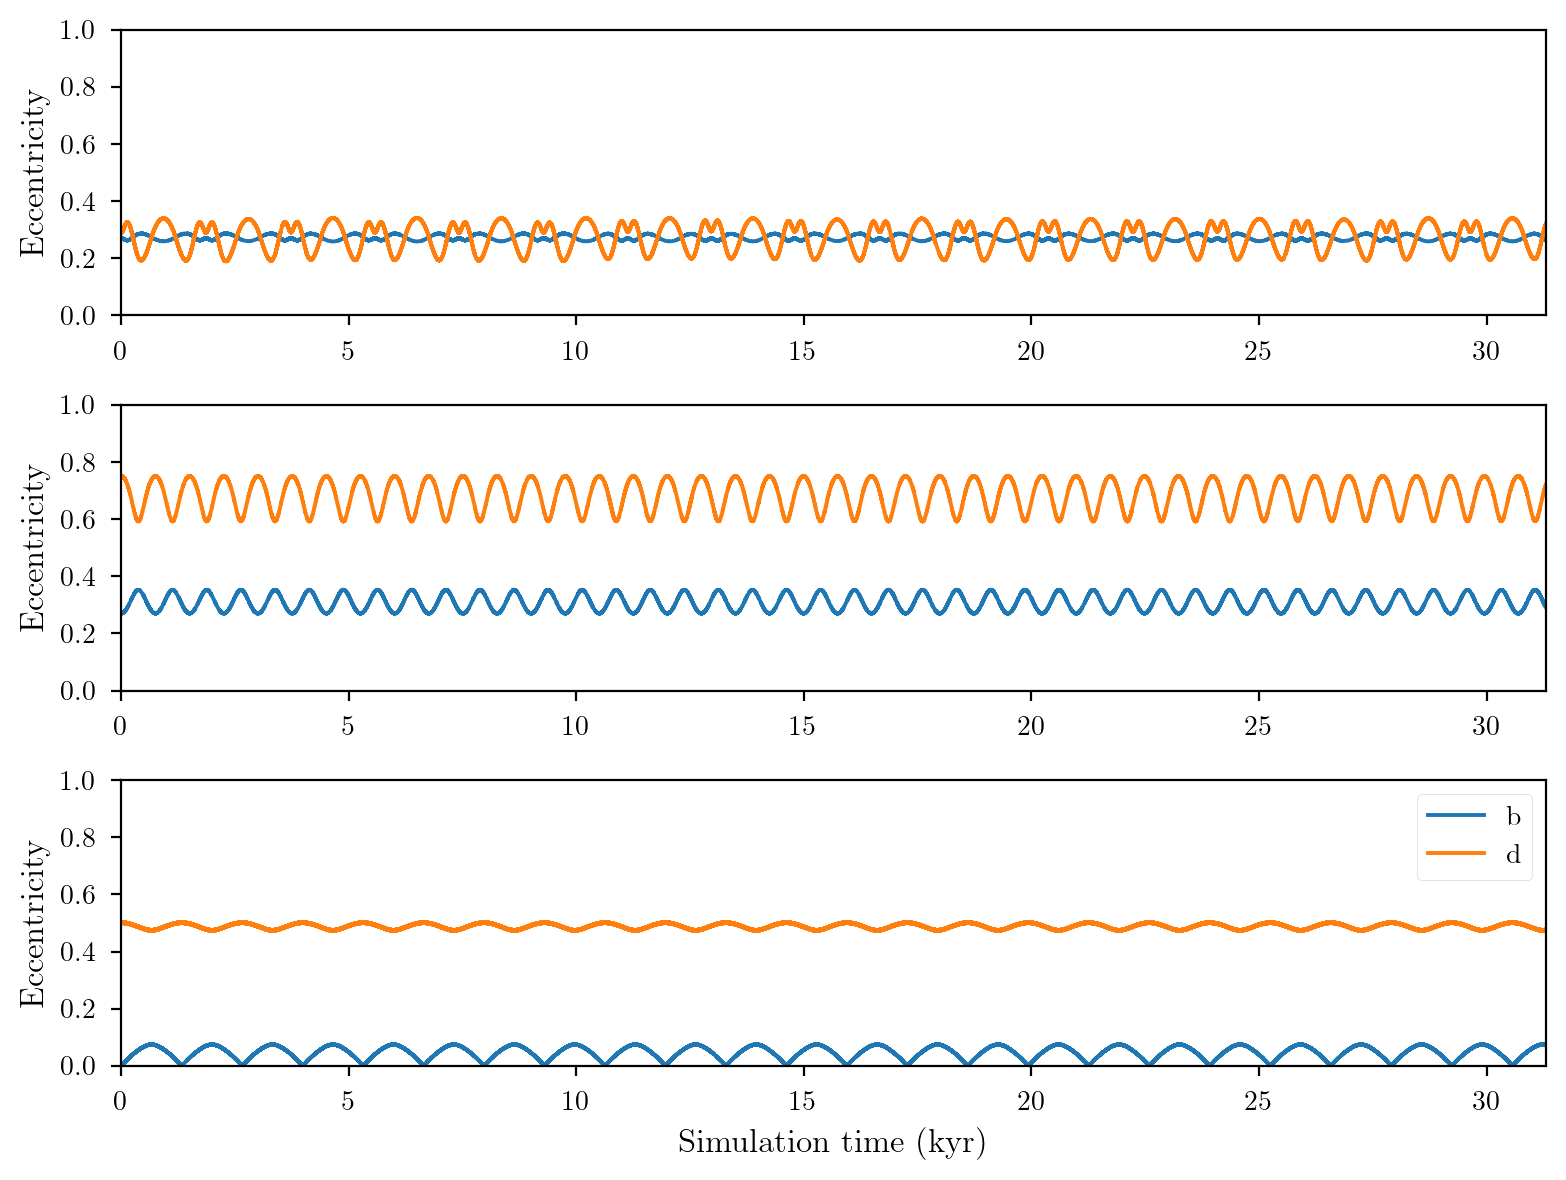

In [661]:
norm = 2. * np.pi * 1000. # conversion from REBOUND time units into kyr

fig, ax = plt.subplots(3, 1, figsize=(8, 6), dpi=200)
ax[0].plot(chaos_1['time']/norm, chaos_1['b_ecc'], label='b')
ax[0].plot(chaos_1['time']/norm, chaos_1['d_ecc'], label='d')
ax[1].plot(chaos_2['time']/norm, chaos_2['b_ecc'], label='b')
ax[1].plot(chaos_2['time']/norm, chaos_2['d_ecc'], label='d')
ax[2].plot(chaos_3['time']/norm, chaos_3['b_ecc'], label='b')
ax[2].plot(chaos_3['time']/norm, chaos_3['d_ecc'], label='d')
for a in ax:
    a.set_xlim(left=0.)
    a.set_ylabel('Eccentricity')
ax[2].set_xlabel('Simulation time (kyr)')
ax[0].set_xlim(right=max(chaos_1['time']/norm))
ax[1].set_xlim(right=max(chaos_2['time']/norm))
ax[2].set_xlim(right=max(chaos_3['time']/norm))
ax[0].set_ylim(top=12.)
for a in ax:
#     a.set_ylim(top=0.35, bottom=0.18)
    a.set_ylim(top=1., bottom=0.)
ax[2].legend(loc=0);

In [499]:
e1 = 0.
e2 = 0.47
min_mass1 = float(0.26 * u.earthMass/u.solMass)
min_mass2 = float(1.07 * u.earthMass/u.solMass)
obs_inc1 = 133.
obs_inc2 = 133.
m1 = min_mass1 / np.sin(obs_inc1)
m2 = min_mass2 / np.sin(obs_inc2)
a1 = 0.029
a2 = 0.049
i1 = 0.
i2 = 0.
Omega1 = 0.
Omega2 = np.pi
pomega1 = 0.
pomega2 = np.pi
par = (m1, m2, a1, a2, e1, e2, i1, i2, Omega1, Omega2, pomega1, pomega2)
chaos_4 = simulation_with_output(par, integrator='whfast')

e1 = 0.5
e2 = 0.4
par = (m1, m2, a1, a2, e1, e2, i1, i2, Omega1, Omega2, pomega1, pomega2)
chaos_5 = simulation_with_output(par, integrator='whfast')

e1 = 0.25
e2 = 0.15
par = (m1, m2, a1, a2, e1, e2, i1, i2, Omega1, Omega2, pomega1, pomega2)
chaos_6 = simulation_with_output(par)

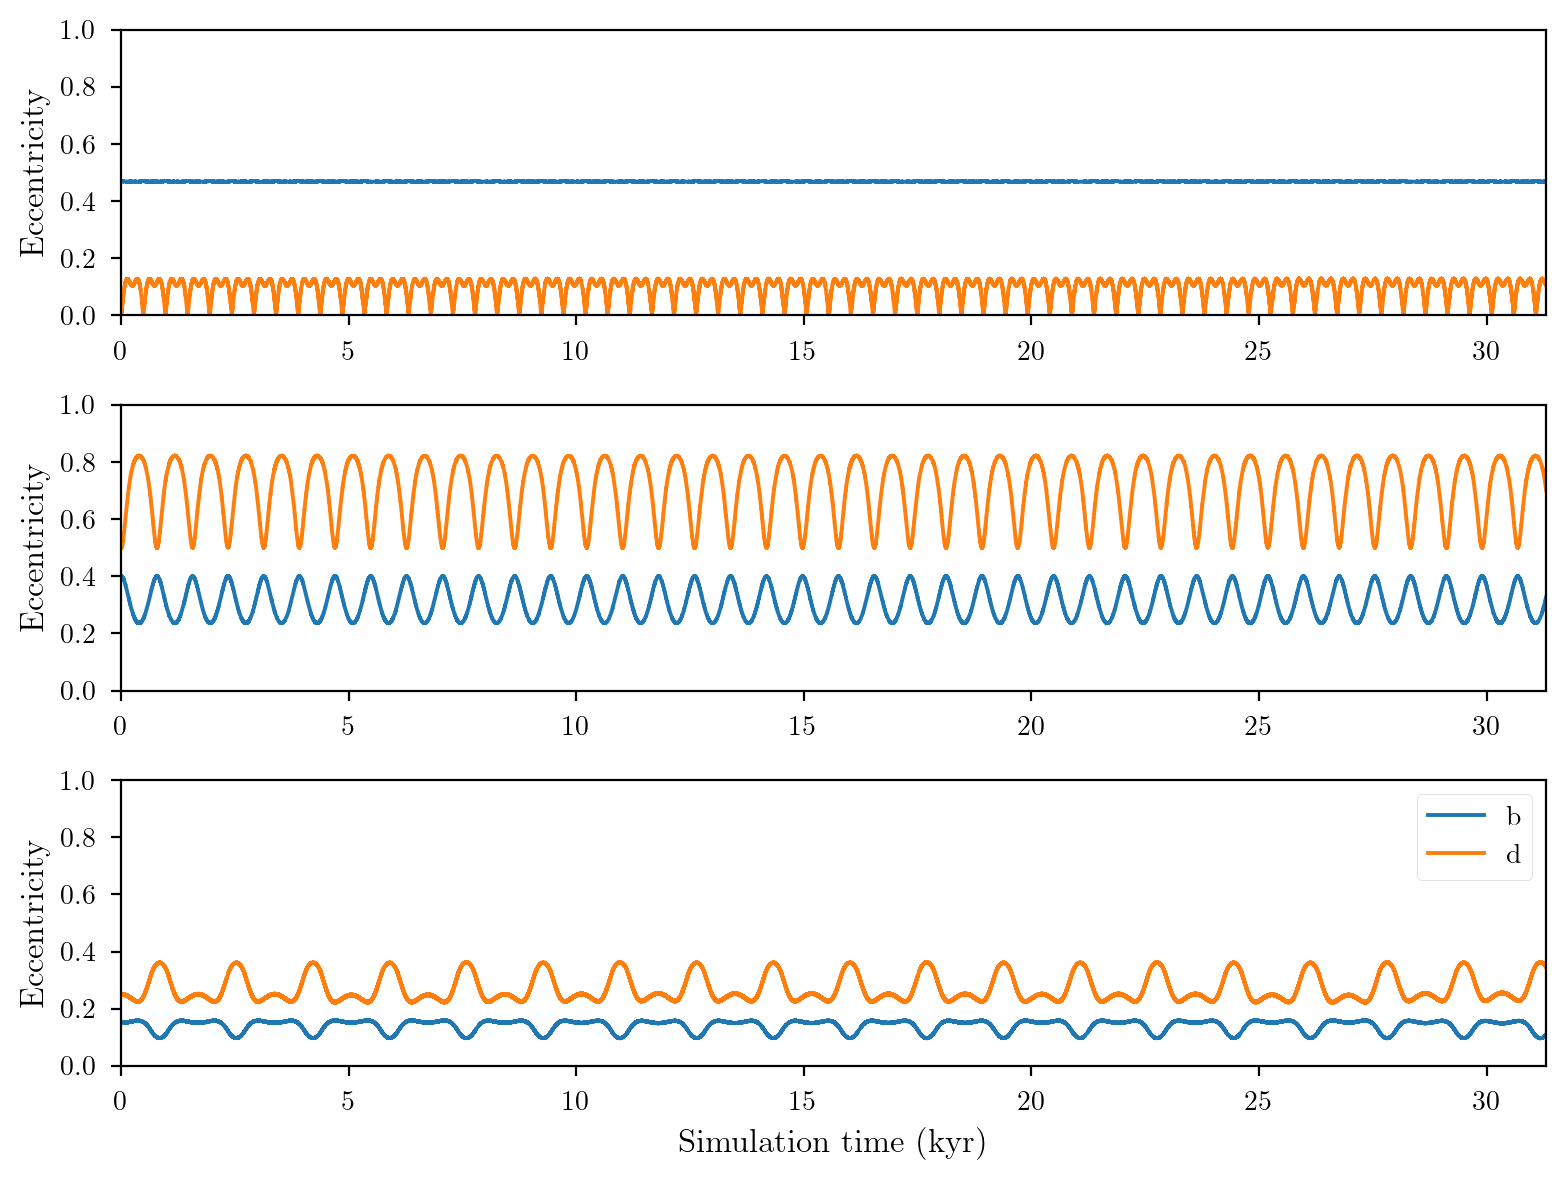

In [500]:
norm = 2. * np.pi * 1000. # conversion from REBOUND time units into kyr

fig, ax = plt.subplots(3, 1, figsize=(8, 6), dpi=200)
ax[0].plot(chaos_4['time']/norm, chaos_4['b_ecc'], label='b')
ax[0].plot(chaos_4['time']/norm, chaos_4['d_ecc'], label='d')
ax[1].plot(chaos_5['time']/norm, chaos_5['b_ecc'], label='b')
ax[1].plot(chaos_5['time']/norm, chaos_5['d_ecc'], label='d')
ax[2].plot(chaos_6['time']/norm, chaos_6['b_ecc'], label='b')
ax[2].plot(chaos_6['time']/norm, chaos_6['d_ecc'], label='d')
for a in ax:
    a.set_xlim(left=0.)
    a.set_ylabel('Eccentricity')
ax[2].set_xlabel('Simulation time (kyr)')
ax[0].set_xlim(right=max(chaos_4['time']/norm))
ax[1].set_xlim(right=max(chaos_5['time']/norm))
ax[2].set_xlim(right=max(chaos_6['time']/norm))
for a in ax:
    a.set_ylim(top=1., bottom=0.)
ax[2].legend(loc=0);

## Long-term (1 Myr) simulations

These data come from five Myr-length simulations with initial conditions in the apparent outlying quasi-periodic regions of Fig. 1. They may be generated by running the script `myr-sims.py`, but note that this will take several days to run. The initial conditions for each of these simulations are as follows.

* `sim1`: $e_d = 0.054, e_b = 0.36$
* `sim2`: $e_d = 0.162, e_b = 0.79$
* `sim3`: $e_d = 0.486, e_b = 0.58$
* `sim4`: $e_d = 0.675, e_b = 0.3$
* `sim5`: $e_d = 0.855, e_b = 0.56$

We observe some libration in the resonant arguments in only one case (`sim2`).

In [95]:
sim1 = pd.read_csv('myr-sim-0.054-0.36.csv')
sim2 = pd.read_csv('myr-sim-0.162-0.79.csv')
sim3 = pd.read_csv('myr-sim-0.486-0.58.csv')
sim4 = pd.read_csv('myr-sim-0.675-0.3.csv')
sim5 = pd.read_csv('myr-sim-0.855-0.56.csv')

In [96]:
names = ['sim1', 'sim2', 'sim3', 'sim4', 'sim5']
sims = [sim1, sim2, sim3, sim4, sim5]

def display_sim(Show):
    for i, name in enumerate(names):
        if Show == name:
            sim = sims[i]
            
    args = ['conj', 'phi1', 'phi3', 'phi32']
    labels = [r'$\lambda_c$', r'$\phi_{2:1}$', r'$\phi_{3:1}$', r'$\phi_{3:2}$']
    ticks = np.array([0., 1., 2.]) * np.pi
    num_plots = 4

    fig, ax = plt.subplots(num_plots, 1, figsize=(5, 6), dpi=200)
    for n in range(num_plots):
        ax[n].scatter(sim['time']/(2.*np.pi), sim[args[n]], c='k', s=0.1)
        ax[n].set_yticks(ticks, ['0', r'$\pi$', r'$2\pi$'])
        ax[n].set_ylabel(labels[n])
        ax[n].set_xlim(0.0e5, 0.1e5)
    ax[num_plots-1].set_xlabel('Simulation time (yr)');

interact(display_sim, Show=names);

interactive(children=(Dropdown(description='Show', options=('sim1', 'sim2', 'sim3', 'sim4', 'sim5'), value='si…

Note that $\lambda_c$ here is the longitude of conjunction, $\lambda_c \equiv 2\lambda' - \lambda$.

The MEGNO after 1 Myr tends away from 2 in each of these cases, indicating that the ones initially found to be quasi-periodic evolve towards chaos later on. This provides further evidence that the outlying islands of apparent stability in Fig. 1 are likely spurious.

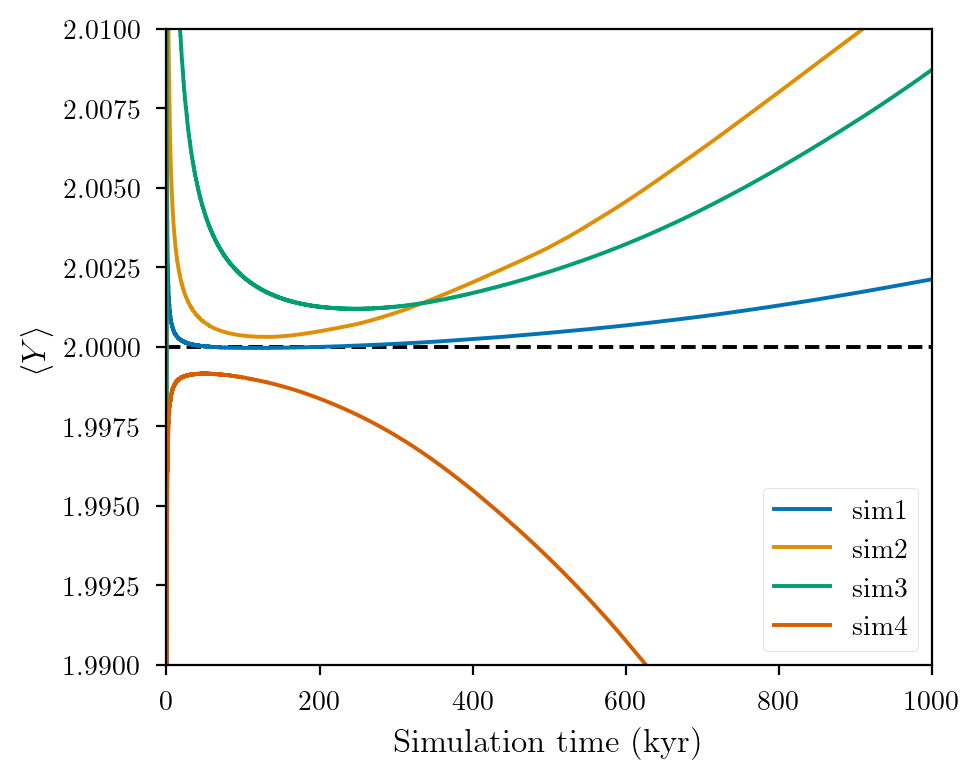

In [60]:
sims = [sim1, sim2, sim3, sim4]
names = ['sim1', 'sim2', 'sim3', 'sim4']
colors = sns.color_palette(palette='colorblind', n_colors=4)

fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=200)
ax.axhline(y=2., ls='--', c='k')
for i, sim in enumerate(sims):
    ax.plot(sim['time']/(2.*np.pi*1000.), sim['megno'], label=names[i], c=colors[i])
ax.set_xlim(0., 1000.)
ax.set_ylim(1.99, 2.01)
# sim = sim1
# ecc_var = np.abs(sim['b_ecc']/sim['b_ecc'][0] - 1.)
# ax.plot(sim['time']/(2.*np.pi*1000.), ecc_var, label=names[i], c=colors[i])
ax.set_xlabel('Simulation time (kyr)')
ax.set_ylabel(r'$\langle Y \rangle$')
ax.legend(loc=4);

After 1 Myr, $\langle Y \rangle \not\to 2$ in each case.

# Planetary mass space

These data are referenced in Sect. 3 (Set II of the simulations).

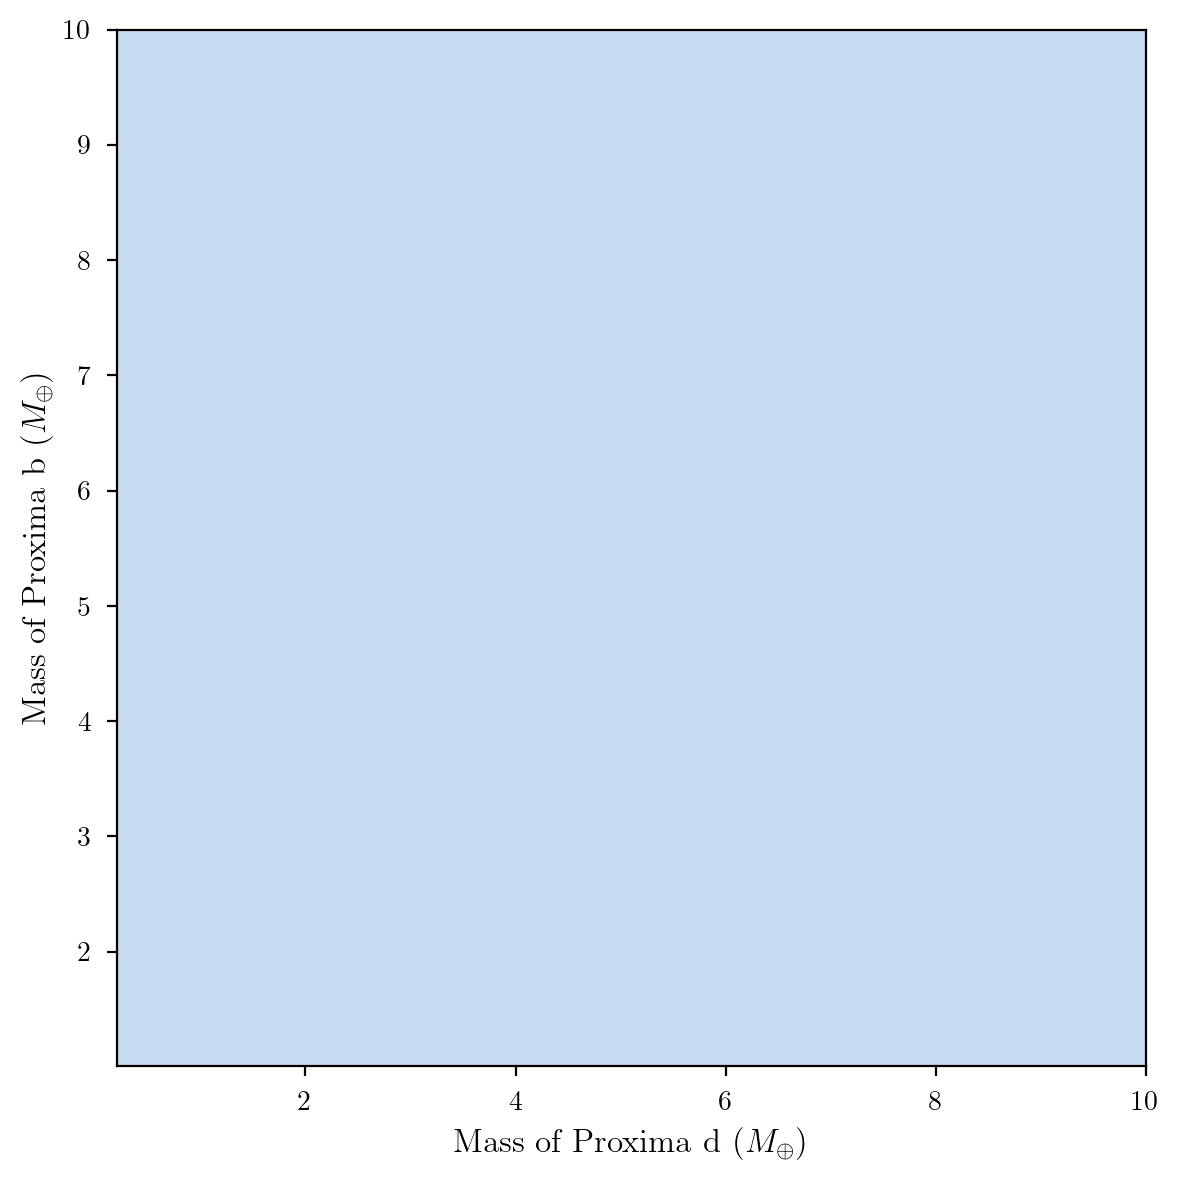

In [6]:
# megno_map_file = '~/Documents/GitHub/ProximaEvolution/hill-stability/mass-megno.txt'

megno_map_file = 'mass-megno.txt'

df = pd.read_csv(megno_map_file, sep=' ', names=column_names, index_col=False)

# Apply masks
stable_df = df.mask(np.fabs(df['megno'] - 2.) > 1.0e-2).dropna()
unstable_df = df.mask(np.fabs(df['megno'] - 2.) < 1.0e-2).dropna()
escape_df = df.mask(df['megno'] != 10.).dropna() # we arbitrarily set MEGNO to 10.0 where escape occurs

df = df.sort_values(by=['b_mass', 'd_mass'])

orbit_type = np.zeros((100, 100))
for k in range(len(df['megno'])):
    j = k % 100
    i = int(np.floor(k/100))
    if np.fabs(df['megno'].iloc[k] - 2.) <= 1e-2: # Criterion of Hinse et al. (2010)
        orbit_type[i][j] = 1. # quasi-periodic
    elif df['megno'].iloc[k] == 10.:
        orbit_type[i][j] = 0. # unstable -- ejection occurs
    else:
        orbit_type[i][j] = 0.5 # chaotic, but not necessarily unstable

X, Y = np.meshgrid(np.linspace(0.21, 10., 100), np.linspace(1.01, 10., 100))

fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=200)
ax.contourf(X, Y, orbit_type.T, cmap='Blues')
ax.set_xlabel(r'Mass of Proxima d ($M_\oplus$)')
ax.set_ylabel(r'Mass of Proxima b ($M_\oplus$)');

# plt.savefig('mass.png', dpi=400)

Note that the color here has no real significance. Every case displayed is quasi-periodic. An all-blue colormap was chosen to agree perceptually with the quasi-periodic cases in the previous figure.

# Inclination space

The following creates Fig. 3.

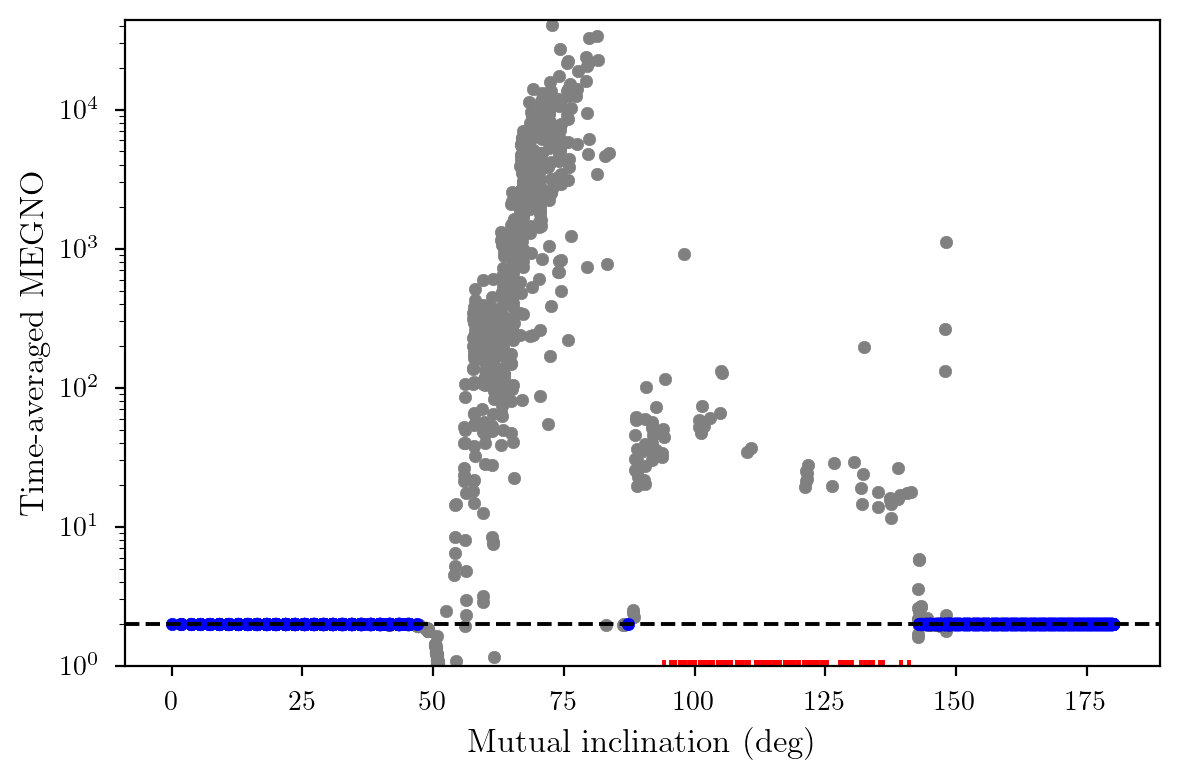

In [517]:
# megno_map_file = '~/Documents/GitHub/ProximaEvolution/hill-stability/inc-megno-2.txt'

megno_map_file = 'inc-megno.txt'
hill_stab_file = '~/Documents/GitHub/ProximaStability/hill-stability/proxhillstabinc.txt'

def mutual_inc(inc1, inc2, lasc1, lasc2):
    cosPsi = np.sin(inc1) * np.sin(inc2) * np.cos(lasc1 - lasc2) + np.cos(inc1) * np.cos(inc2)
    return np.arccos(cosPsi) * 180./np.pi

df = pd.read_csv(megno_map_file, sep=' ', names=column_names, index_col=False)

# Hill stability data (calculated with prox_hill_stab.c)
hill_stab_cols = ['exact', 'approx', 'd_mass', 'b_mass', 'd_semi', 'b_semi',
                'd_ecc', 'b_ecc', 'd_aper', 'b_aper', 'd_inc', 'b_inc',
                'd_lasc', 'b_lasc', 'd_mean_an', 'b_mean_an']
hillstab = pd.read_csv(hill_stab_file, sep=' ', names=hill_stab_cols, index_col=False)
mutual_incs = mutual_inc(hillstab['d_inc'], hillstab['b_inc'], hillstab['d_lasc'], hillstab['b_lasc'])

# Apply masks
periodic_df = df.mask(np.fabs(df['megno'] - 2.) > 1.0e-2).mask(df['megno'] == 10.).dropna()
chaotic_df = df.mask(np.fabs(df['megno'] - 2.) < 1.0e-2).mask(df['megno'] == 10.).dropna()
escape_df = df.mask(df['megno'] != 10.).dropna() # we arbitrarily set MEGNO to 10.0 where escape occurs

periodic_mutual_incs = mutual_inc(periodic_df['d_inc'], periodic_df['b_inc'], periodic_df['d_Omega'], periodic_df['b_Omega'])
chaotic_mutual_incs = mutual_inc(chaotic_df['d_inc'], chaotic_df['b_inc'], chaotic_df['d_Omega'], chaotic_df['b_Omega'])
escape_mutual_incs = mutual_inc(escape_df['d_inc'], escape_df['b_inc'], escape_df['d_Omega'], escape_df['b_Omega'])
escape_ticks = np.ones_like(escape_df['megno'])

fig, ax = plt.subplots(1, 1, dpi=200)
# ax.scatter(bound_mutual_incs, bound_df['megno'], s=20)
ax.scatter(escape_mutual_incs, escape_ticks, s=20, marker='|', c='r')
ax.scatter(chaotic_mutual_incs, chaotic_df['megno'], s=20, c='gray')
ax.scatter(periodic_mutual_incs, periodic_df['megno'], s=20, c='b')
ax.axhline(2., c='k', ls='--')
ax.set_ylim(bottom=1.)
ax.set_yscale('log')
ax.set_xlabel(r'Mutual inclination (deg)')
ax.set_ylabel('Time-averaged MEGNO');
# fig.savefig('mutual-incs.pdf', dpi=400, bbox_inches='tight');

In the range $95^\circ < \Psi < 142^\circ$, roughly $81\%$ of simulated cases result in instabilities.

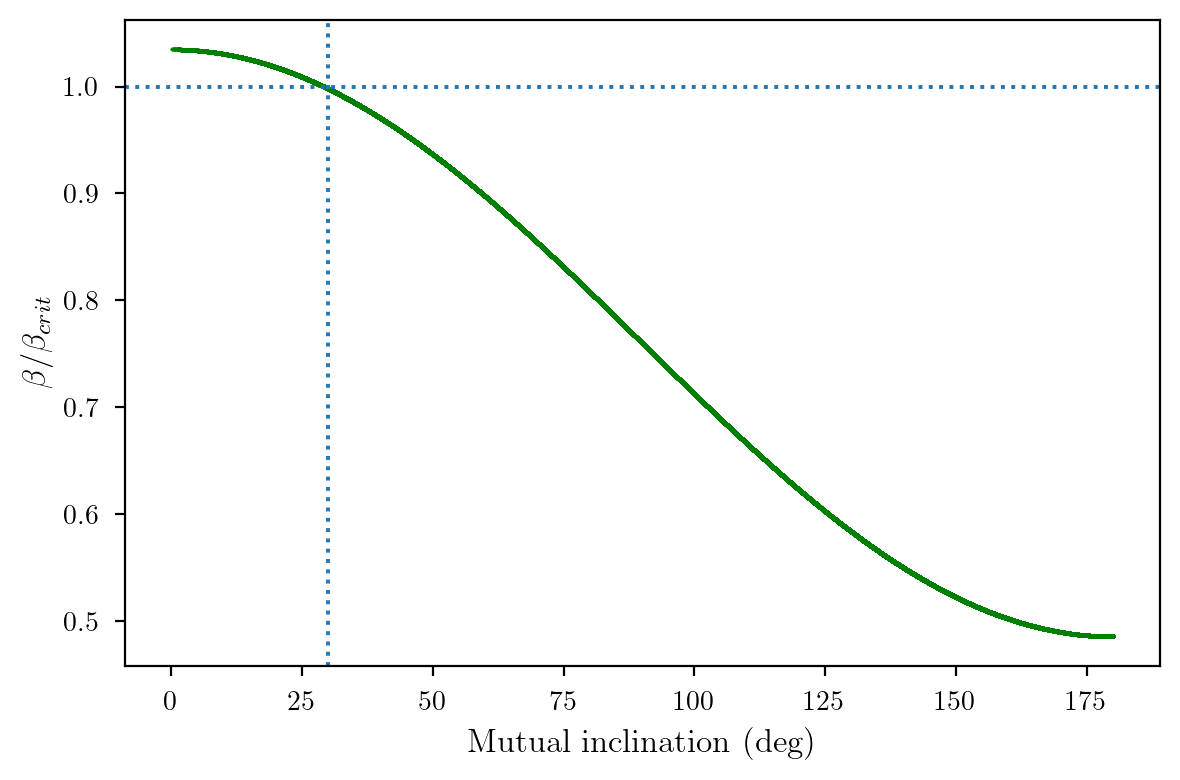

In [524]:
fig, ax = plt.subplots(1, 1, dpi=200)
ax.scatter(mutual_incs, hillstab['exact'], s=1., c='g')
ax.axhline(1., ls=':')
ax.axvline(30., ls=':')
ax.set_xlabel('Mutual inclination (deg)')
ax.set_ylabel(r'$\beta/\beta_{crit}$');

The Hill stability parameter $\beta/\beta_\text{crit} \leq 1$ for $\Psi > 30^\circ$, which suggests that systems in this domain are not guaranteed to be Hill stable. While this result agrees with the MEGNO plot above, it fails to demonstrate certain features like the stability of many retrograde configurations.

In [8]:
num_chaos = len(chaotic_mutual_incs.mask(chaotic_mutual_incs > 142.).mask(chaotic_mutual_incs < 95.).dropna())
num_eject = len(escape_mutual_incs.mask(escape_mutual_incs > 142.).mask(escape_mutual_incs < 95.).dropna())
num_eject / (num_eject + num_chaos)

0.8159203980099502

The following cell creates Fig. 4. Note that we don't bother with the Hill stability boundary here because every tested case in this sample is Hill stable.

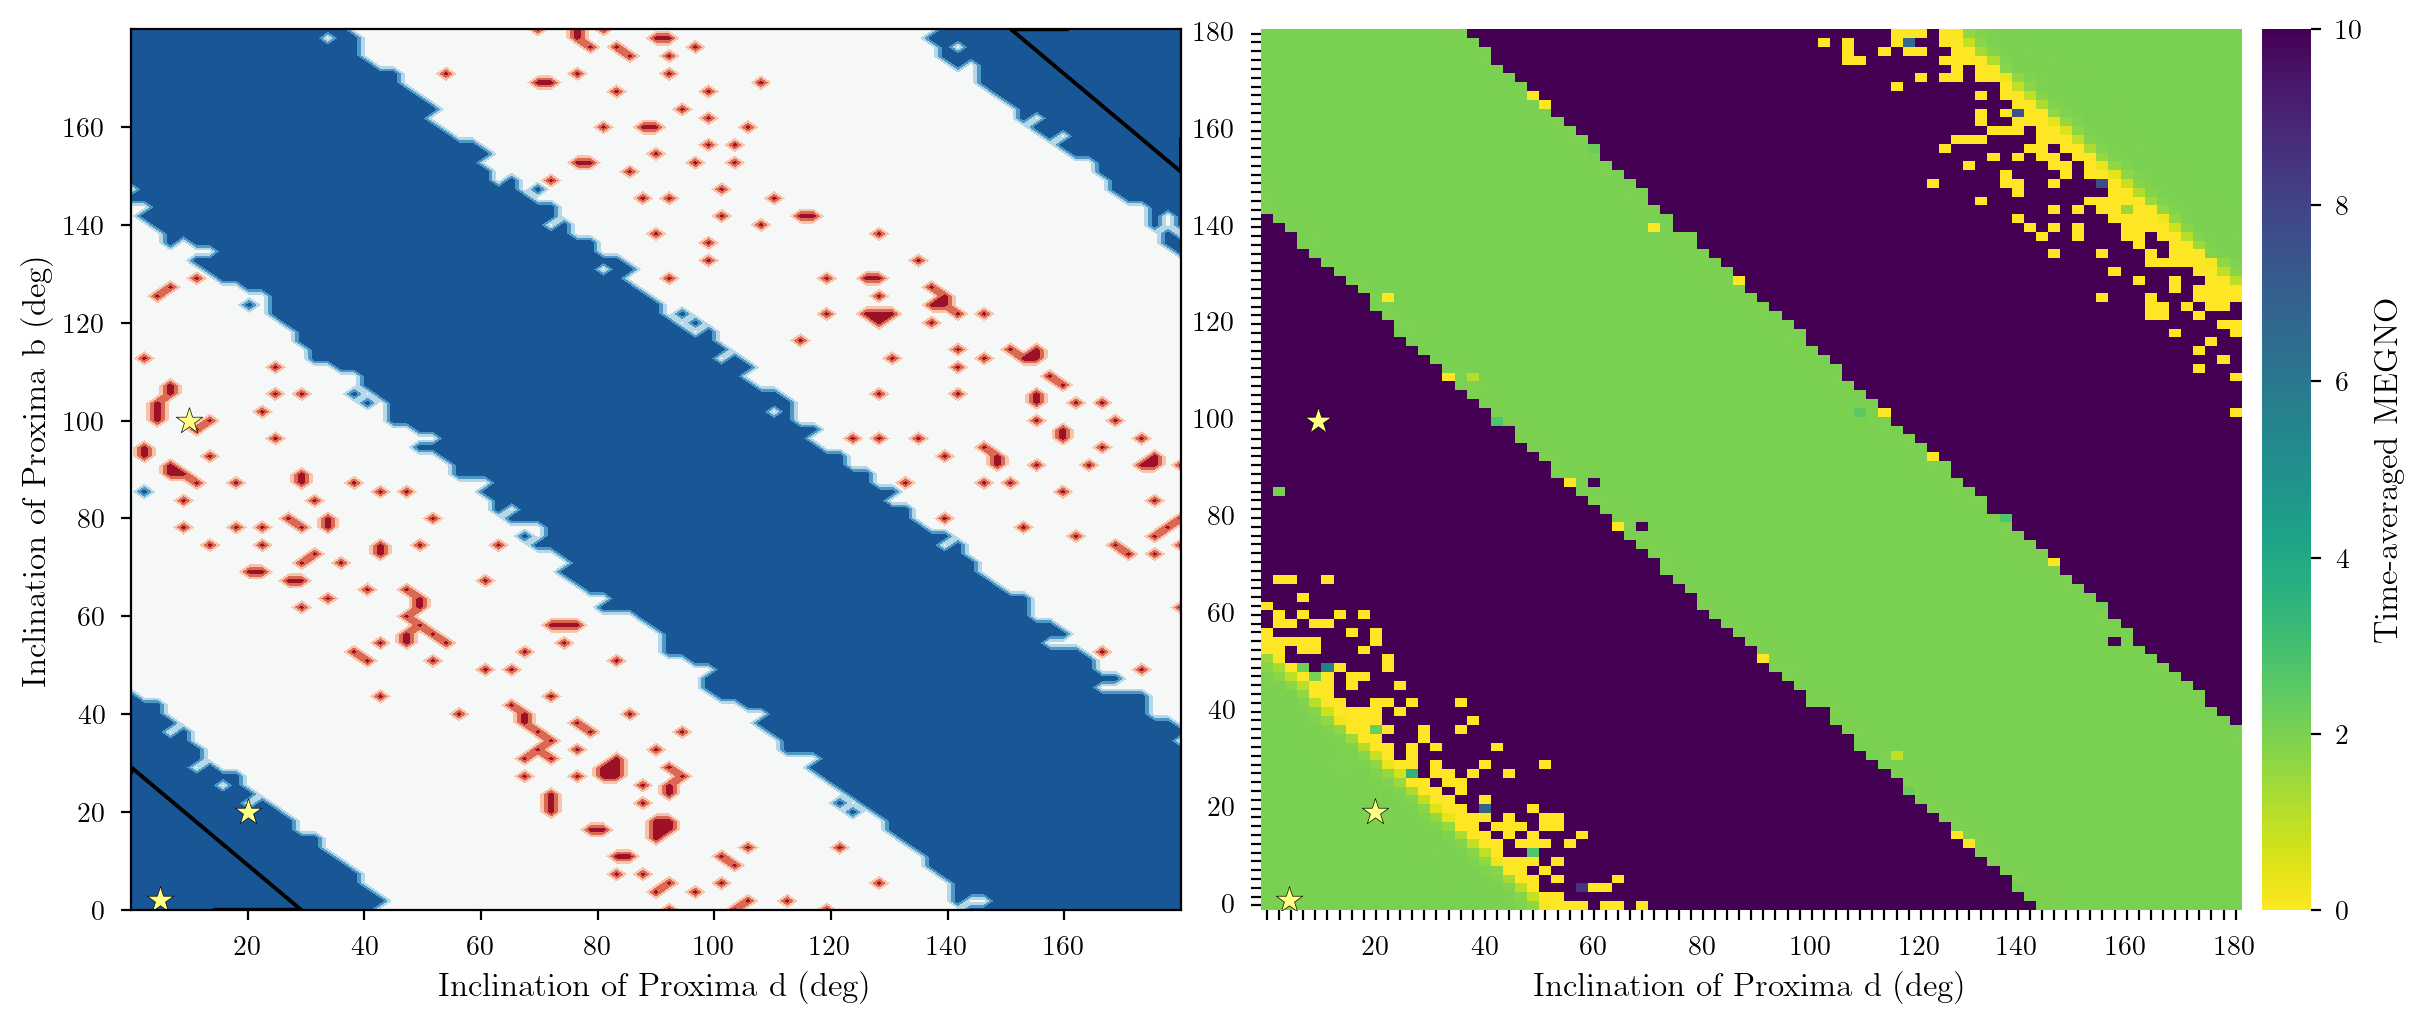

In [520]:
megno_map_file = '~/Documents/GitHub/ProximaEvolution/hill-stability/inc-megno.txt'
megno_map_supp = '~/Documents/GitHub/ProximaStability/stability-maps/inc-megno-finish.txt'
hill_stab_file = '~/Documents/GitHub/ProximaStability/hill-stability/proxhillstabinc.txt'

# megno_map_file = 'inc-megno.txt'
# hill_stab_file = '../hill-stability/proxhillstabinc.txt'

column_names = ['d_mass', 'b_mass', 'd_semi', 'b_semi', 'd_ecc', 'b_ecc', 'd_inc', 'b_inc', 'd_Omega', 'b_Omega', 'd_pomega', 'b_pomega', 'megno']
df = pd.read_csv(megno_map_file, sep=' ', names=column_names, index_col=False)

# Hill stability data (calculated with prox_hill_stab.c)
hill_stab_cols = ['exact', 'approx', 'd_mass', 'b_mass', 'd_semi', 'b_semi',
                'd_ecc', 'b_ecc', 'd_aper', 'b_aper', 'd_inc', 'b_inc',
                'd_lasc', 'b_lasc', 'd_mean_an', 'b_mean_an']
hillstab = pd.read_csv(hill_stab_file, sep=' ', names=hill_stab_cols, index_col=False)

# Combining/cleaning up the data
df = df.drop_duplicates(subset=['d_inc', 'b_inc'])
if megno_map_supp != None:
    df_supp = pd.read_csv(megno_map_supp, sep=' ', names=column_names, index_col=False)
    df_supp = df_supp.drop_duplicates(subset=['d_inc', 'b_inc'])
    df = pd.concat([df, df_supp]).drop_duplicates(subset=['d_inc', 'b_inc'])
    
df = df.drop_duplicates(subset=['d_inc', 'b_inc'])
df = df.sort_values(by=['b_inc', 'd_inc'])
    
# Some of the original simulations had inclinations beyond the desired range
indices_to_drop = []
for i, idx in enumerate(df.index):
    if df['d_inc'].iloc[i] > np.pi:
        indices_to_drop.append(idx)
df = df.drop(index=indices_to_drop)

# Make MEGNO heatmap
megno_map = np.zeros((81, 100))
for k in range(len(df['megno'])):
    i = k % 81
    j = int(np.floor(k/81.))
    m = df['megno'].iloc[k]
    if np.isnan(m):
        m = 10.
    elif m > 10.:
        m = 10.
    elif m < 0.:
        m = 0.
    megno_map[i][j] = m

# Assign quasi-periodic/chaotic/unstable designation
orbit_type = np.zeros((81, 100))
for k in range(len(df['megno'])):
    i = k % 81
    j = int(np.floor(k/81.))
    orbit_type[i][j] = df['megno'].iloc[k]
    if np.fabs(df['megno'].iloc[k] - 2.) <= 1e-2: # Criterion of Hinse et al. (2010)
        orbit_type[i][j] = 1. # quasi-periodic
    elif (df['megno'].iloc[k] == 10.):
        orbit_type[i][j] = 0. # unstable -- ejection occurs
#     elif df['megno'].iloc[k] == 0.:
#         orbit_type[i][j] = 0.5 # no data -- for some reason, the simulation didn't finish
    else:
        orbit_type[i][j] = 0.5 # chaotic, but not necessarily unstable

# Make tick labels
d_tick_labels = [int(n) for n in np.round_(np.linspace(0., np.pi, 81) * 180./np.pi, decimals=0)]
b_tick_labels = [int(n) for n in np.round_(np.linspace(0., np.pi, 100) * 180./np.pi, decimals=0)]
multiples_of_20 = 1
for k, i in enumerate(d_tick_labels):
    if i < multiples_of_20 * 20:
        d_tick_labels[k] = ''
    else:
        d_tick_labels[k] = str(np.round_(i, decimals=-1))
        multiples_of_20 += 1
for k, i in enumerate(b_tick_labels):
    if i not in [int(i) for i in np.round_(np.linspace(0., np.pi, 10) * 180./np.pi, decimals=0)]:
        b_tick_labels[k] = ''
    else:
        b_tick_labels[k] = str(i)

X, Y = np.meshgrid(np.linspace(0., np.pi, 81) * 180./np.pi, np.linspace(0., np.pi, 100) * 180./np.pi)

# Create figure
fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi=200)
divider = make_axes_locatable(ax[1])
cmap = 'viridis_r'
cax = divider.append_axes('right', size='5%', pad=0.1)
ax[0].contourf(X, Y, orbit_type.T, cmap='RdBu')
ax[0].tricontour(hillstab['d_inc'] * 180./np.pi,
                 hillstab['b_inc'] * 180./np.pi,
                 hillstab['exact'],
                 levels=[1.],
                 colors='k'
                )
with sns.axes_style('ticks'):
    hm = sns.heatmap(megno_map.T,
                     vmin=0.,
                     vmax=10.,
                     cmap=cmap,
                     xticklabels=d_tick_labels,
                     yticklabels=b_tick_labels,
                     square=False,
                     cbar=True,
                     cbar_kws={'label':'Time-averaged MEGNO'},
                     cbar_ax=cax,
                     ax=ax[1]
                    )
    hm.set_yticklabels(hm.get_yticklabels(), rotation=0)

# Locations of simulations in Fig. 4
d_sample = np.array([5., 20., 10.])
b_sample = np.array([2., 20., 100.])
ax[0].scatter(d_sample, b_sample, marker='*', s=100, c='xkcd:pale yellow', edgecolor='k')
ax[1].scatter(d_sample*85./180., b_sample*100./180., marker='*', s=100, c='xkcd:pale yellow', edgecolor='k')
ax[1].invert_yaxis()
# ax[0].set_xlim(left=9.)
for a in ax:
    a.tick_params(which='minor', bottom=False, left=False)
    a.set_xlabel('Inclination of Proxima d (deg)')
ax[0].set_ylabel('Inclination of Proxima b (deg)');
# fig.savefig('varying-inc.pdf', dpi=400, bbox_inches='tight')

The following creates Fig. 5. Again, note that the example simulations will take several minutes each.

In [601]:
# Example case with quasi-periodic motion (Psi = 3 deg)
e1 = 0.
e2 = 0.
min_mass1 = float(0.26 * u.earthMass/u.solMass)
min_mass2 = float(1.07 * u.earthMass/u.solMass)
obs_inc1 = 133. * np.pi/180.
obs_inc2 = 133. * np.pi/180.
m1 = min_mass1 / np.sin(obs_inc1)
m2 = min_mass2 / np.sin(obs_inc2)
a1 = 0.029
a2 = 0.049
i1 = 5. * np.pi/180.
i2 = 2. * np.pi/180.
Omega1 = 0.
Omega2 = 0.
pomega1 = 0.
pomega2 = np.pi
par = (m1, m2, a1, a2, e1, e2, i1, i2, Omega1, Omega2, pomega1, pomega2)
inc_stable_sim = simulation_with_output(par, integrator='whfast')

# Example case with chaotic motion (Psi = 60 deg)
# i1 = 20. * np.pi/180.
# i2 = 30. * np.pi/180.
# Omega2 = np.pi
# par = (m1, m2, a1, a2, e1, e2, i1, i2, Omega1, Omega2, pomega1, pomega2)
# inc_chaotic_sim = simulation_with_output(par, integrator='whfast')
# Example case with chaotic motion (Psi = 135 deg)
i1 = 105. * np.pi/180.
i2 = 30. * np.pi/180.
Omega2 = np.pi
par = (m1, m2, a1, a2, e1, e2, i1, i2, Omega1, Omega2, pomega1, pomega2)
inc_chaotic_sim = simulation_with_output(par, integrator='whfast')

# Example case with ejection (Psi = 110 deg)
i1 = 10. * np.pi/180.
i2 = 100. * np.pi/180.
par = (m1, m2, a1, a2, e1, e2, i1, i2, Omega1, Omega2, pomega1, pomega2)
inc_unstable_sim = simulation_with_output(par)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/rebound/simulation.py:935: RuntimeWarning: At least 10 predictor corrector loops in IAS15 did not converge. This is typically an indication of the timestep being too large.
  warnings.warn(msg[1:], RuntimeWarning)


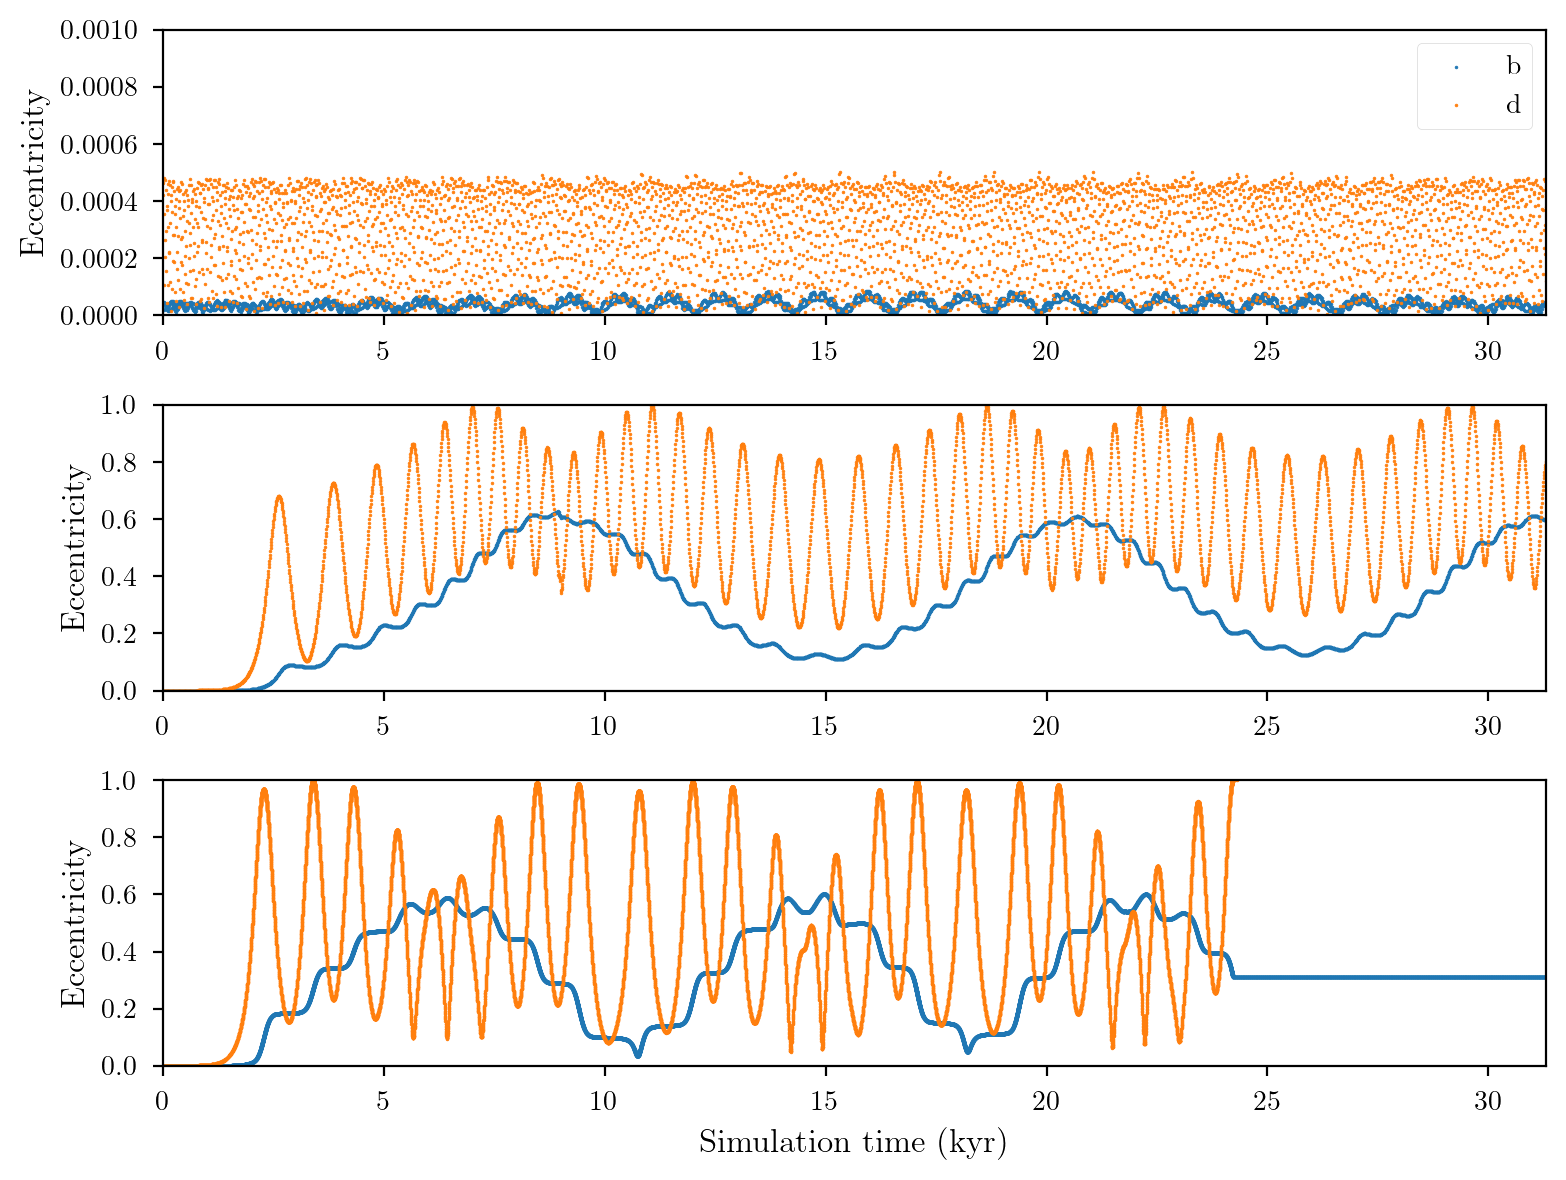

In [642]:
norm = 2. * np.pi * 1000. # conversion from REBOUND time units into kyr

stable_time = [inc_stable_sim['time'].iloc[i]/norm for i in inc_stable_sim.index if i % 100 == 0]
stable_d_ecc = [inc_stable_sim['d_ecc'].iloc[i] for i in inc_stable_sim.index if i % 100 == 0]
stable_b_ecc = [inc_stable_sim['b_ecc'].iloc[i] for i in inc_stable_sim.index if i % 100 == 0]
chaotic_time = [inc_chaotic_sim['time'].iloc[i]/norm for i in inc_chaotic_sim.index if i % 100 == 0]
chaotic_d_ecc = [inc_chaotic_sim['d_ecc'].iloc[i] for i in inc_chaotic_sim.index if i % 100 == 0]
chaotic_b_ecc = [inc_chaotic_sim['b_ecc'].iloc[i] for i in inc_chaotic_sim.index if i % 100 == 0]
unstable_time = [inc_unstable_sim['time'].iloc[i]/norm for i in inc_unstable_sim.index if i % 100 == 0]
unstable_d_ecc = [inc_unstable_sim['d_ecc'].iloc[i] for i in inc_unstable_sim.index if i % 100 == 0]
unstable_b_ecc = [inc_unstable_sim['b_ecc'].iloc[i] for i in inc_unstable_sim.index if i % 100 == 0]

fig, ax = plt.subplots(3, 1, figsize=(8, 6), dpi=200)
ax[0].scatter(stable_time, stable_b_ecc, s=1., label='b')
ax[0].scatter(stable_time, stable_d_ecc, s=1., label='d')
ax[1].scatter(chaotic_time, chaotic_b_ecc, s=1., label='b')
ax[1].scatter(chaotic_time, chaotic_d_ecc, s=1., label='d')
ax[2].scatter(unstable_time, unstable_b_ecc, s=1., label='b')
ax[2].scatter(unstable_time, unstable_d_ecc, s=1., label='d')
for a in ax:
    a.set_xlim(left=0.)
    a.set_xlim(right=max(stable_time))
    a.set_ylim(bottom=0.)
    a.set_ylabel('Eccentricity')
ax[0].set_ylim(top=0.001)
ax[1].set_ylim(top=1.)
ax[2].set_ylim(top=1.)
ax[2].set_xlabel('Simulation time (kyr)')
ax[0].legend(loc=0);
# fig.savefig('evols-d5b2-d20b30-d10b100.pdf', bbox_inches='tight')

## AMD Stuff

In units where $G m_\star = 1$, the *angular momentum deficit* of an $N$-body system (with all circular orbits) is given by

$$ \mathcal{C} = \frac{1}{m_\star} \sum_{k=1}^N \Lambda_k \left [ 1 - \cos(i_k) \right ], $$

where $\Lambda_k = m_k \sqrt{a_k}$.

In [549]:
def mutual_inc(inc1, inc2):
    cosPsi = np.cos(inc1) * np.cos(inc2) - np.sin(inc1) * np.sin(inc2)
    return np.arccos(cosPsi) * 180./np.pi

def amd(inc1, inc2):
    amd1 = (0.299 * u.earthMass)/(0.12 * u.solMass) * np.sqrt(0.029 * u.AU) * (1 - np.cos(inc1))
    amd2 = (1.231 * u.earthMass)/(0.12 * u.solMass) * np.sqrt(0.049 * u.AU) * (1 - np.cos(inc2))
    return float((amd1 + amd2).decompose() / u.AU**(0.5))

<ipython-input-549-1529cae66a8e>:3: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(cosPsi) * 180./np.pi


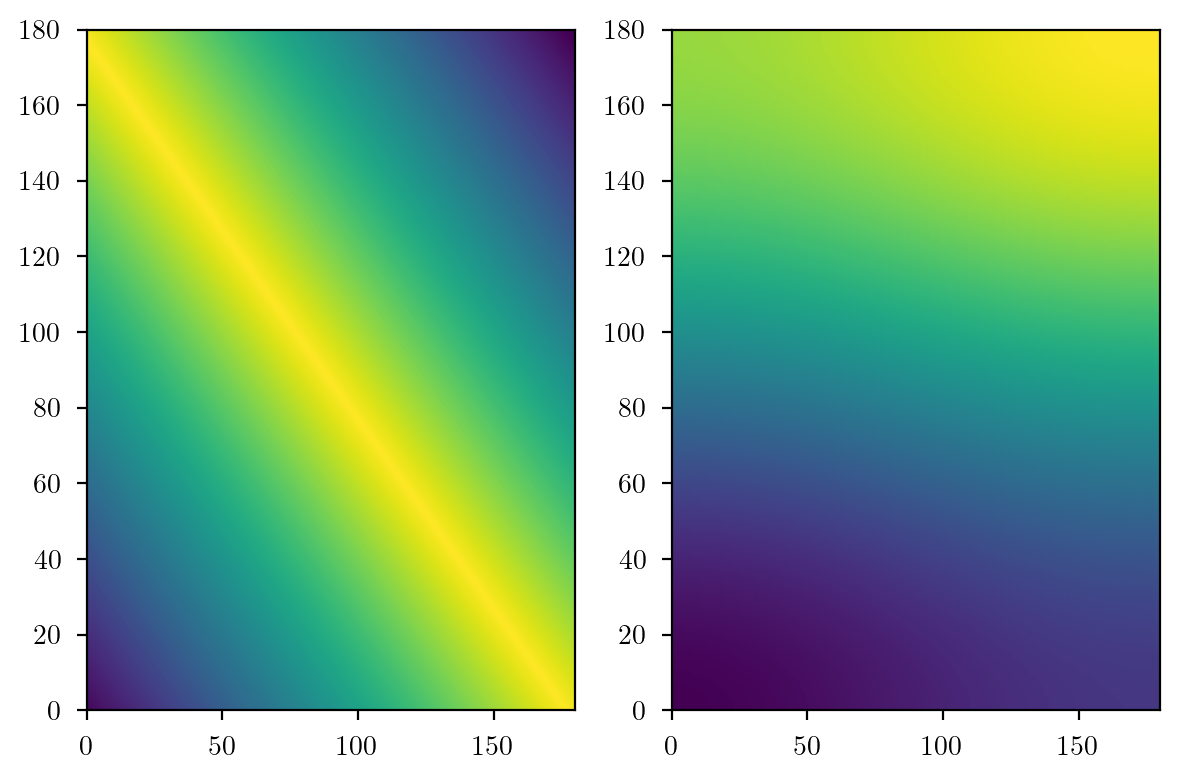

In [561]:
from matplotlib import cm

d_range = np.arange(181) * np.pi/180.
b_range = np.arange(181) * np.pi/180.

d_incs = []
b_incs = []
mutual_incs = []
amds = []

for i1 in d_range:
    for i2 in b_range:
        d_incs.append(i1*180./np.pi)
        b_incs.append(i2*180./np.pi)
        mutual_incs.append(mutual_inc(i1, i2))
        amds.append(amd(i1, i2))

fig, ax = plt.subplots(1, 2, dpi=200)
for a in ax:
    a.set_xlim(0., 180.)
    a.set_ylim(0., 180.)
ax[0].scatter(d_incs, b_incs, c=mutual_incs)
ax[1].scatter(d_incs, b_incs, c=amds);

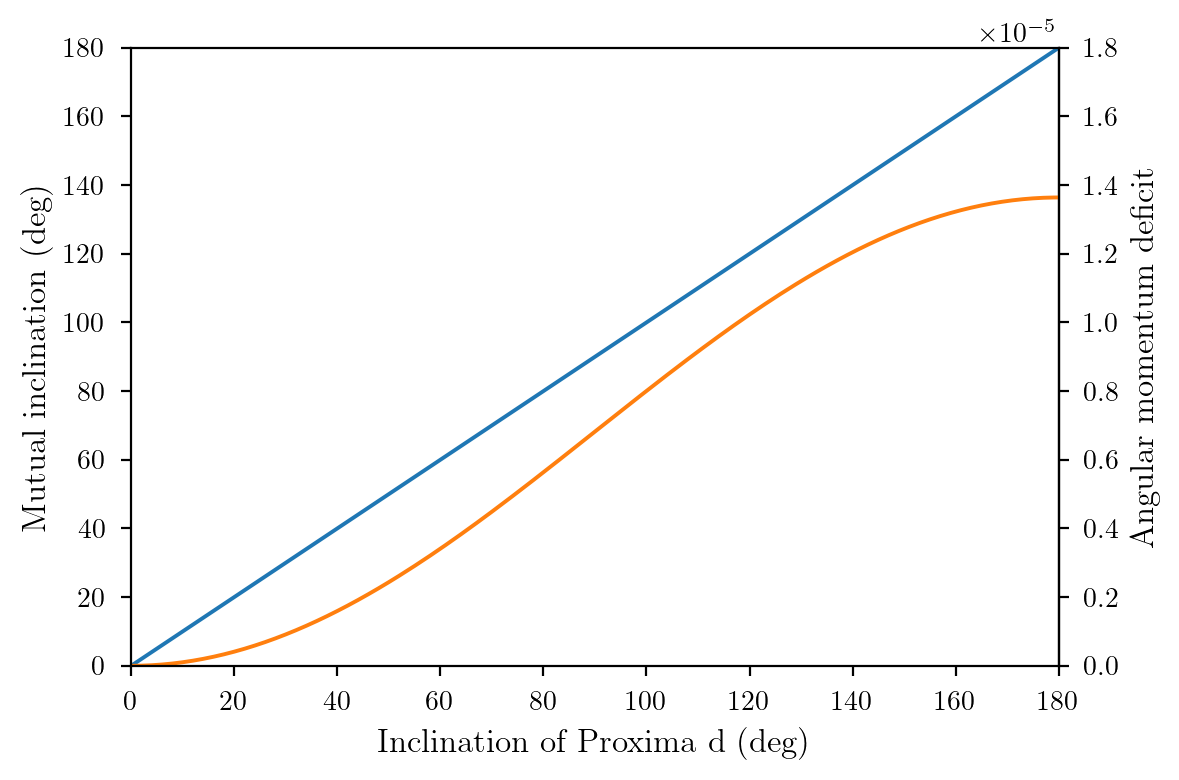

In [593]:
d_range = np.arange(181) * np.pi/180.

d_incs = []
mutual_incs = []
amds = []

i1 = 0.
for i2 in d_range:
    d_incs.append(i2*180./np.pi)
    mutual_incs.append(mutual_inc(i1, i2))
    amds.append(amd(i1, i2) * 1.e7)

fig, ax = plt.subplots(1, 1, dpi=200)
ax.plot(d_incs, mutual_incs)
ax.plot(d_incs, amds)
ax.set_xlim(0., 180.)
ax.set_ylim(0., 180.)
ax.set_xlabel('Inclination of Proxima d (deg)')
ax.set_ylabel('Mutual inclination (deg)')
def multiply_by_10_million(x):
    return x * 1.e7
def divide_by_10_million(x):
    return x / 1.e7
secax = ax.secondary_yaxis('right', functions=(divide_by_10_million, multiply_by_10_million))
secax.set_ylabel('Angular momentum deficit');

From Laskar (1997); Laskar & Petit (2017); He et al. (2020), the *critical AMD* for a two-planet system is given by

$$ \mathcal{C}_\text{crit} = \frac{\gamma}{\gamma + 1} \frac{\eta^2}{2} + \mathcal{O}(\eta^3), $$

where $\gamma = m/m'$ and $\eta = 1 - a/a'$. Such a system is *AMD stable* (i.e., will experience no collisions) with strictly circular orbits if and only if

$$ \mathcal{C}_\text{crit} > 0. $$

In [562]:
gamma = 0.26/1.07
eta = 1. - 0.029/0.049

0.5 * gamma/(gamma + 1.) * eta**2. > 0.

True

For circular orbits, the criterion for AMD stability against the effects of MMRs is simply

$$ \frac{a}{a'} < 1 - 1.46\epsilon^{2/7}, $$

where $\epsilon = (m + m')/m_\star$ (Wisdom 1980, He et al. 2020).

In [594]:
0.029/0.049 < 1. - 1.46 * ((0.26 + 1.07) * u.earthMass * np.sin(133.*np.pi/180.)/(0.12 * u.solMass)) ** (2./7.)

True

In both of these respects, the system is AMD stable.